# ECBM 4040 Fall '21 Project  - BIOM Group

# Hyperparameter Tuning: NeuroSEED Linear Model (with gradient clipping)

In this notebook, we will compare the various the distance functions and their respective loss. We will also do hyperparameter tunning for the hyperbolic and euclidean distance and see what hyperparmeters are best and how they differ from the papers hyperparamters. This is all doing with the MLP archecture of our Deep Learning Model.

## Initialization

In [ ]:
import numpy as np
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt

import shutil
import os

from model.models_cstm import get_embedding_model
from model.train_model import train_siamese_model

!pip3 install keras-tuner
import keras_tuner


In [2]:
#mapping of different distances
DISTANCE_METRICS = {
    'EUCLIDEAN': 'euclidean',
    'HYPERBOLIC': 'hyperbolic',
    'MANHATTAN': 'manhattan',
    'SQUARE': 'square',
    'COSINE': 'cosine'
}

In [3]:
# set random number seeds for reproducible results
np.random.seed(1)
tf.random.set_seed(1)

In [4]:
# set static parameters
MODEL_CHOICE = 'MLP'
DEFAULT_BATCH_SIZE = 1024
NUM_EPOCHS = 5
TRAIN_DAT_LIM = np.nan

# set tuning parameters to search over
LR_SELECTIONS = [1e-2, 1e-3, 1e-4]
DROPOUT_SELECTIONS = [0.3, 0.5, 0.7]
ACTIVATION_SELECTIONS = ['relu','relu','tanh']
NUM_UNITS_SELECTIONS = [128, 256, 512] # NOTE: Not used for linear model
NUM_FILTERS_SELECTIONS = [2,3,4] # NOTE: Not used for linear model
#raise('PLACEHOLDER FOR BATCH SIZE')


In [11]:
# set paths
dist_res_path = "results/{0}_clipgrad/".format(MODEL_CHOICE.lower())

try:
    os.mkdir(dist_res_path)
except:
    pass

hyp_tuner_project_name="random_search_hyp_{0}_clipgrad".format(MODEL_CHOICE.lower())
euc_tuner_project_name="random_search_euc_{0}_clipgrad".format(MODEL_CHOICE.lower())

## Get Qiita Data

In [6]:
cwd = os.getcwd()
if not os.path.exists(f"{cwd}/data/qiita/qiita_numpy.pkl"):
    !wget https://www.dropbox.com/s/mv546rx259tgwaz/qiita_numpy.pkl
    shutil.move(f"{cwd}/qiita_numpy.pkl", f"{cwd}/data/qiita/qiita_numpy.pkl")

## Load Qiita Dataset

In [7]:
# Load QIITA dataset.
((X_train, X_test, X_val), (y_train, y_test, y_val)) = pickle.load(open(f"{cwd}/data/qiita/qiita_numpy.pkl", "rb"))
print('X_train sample:\n{0}'.format(X_train))
dat_lim = TRAIN_DAT_LIM if not np.isnan(TRAIN_DAT_LIM) else len(X_train)
data = ((X_train[:dat_lim], X_test[:dat_lim], X_val[:dat_lim]), (y_train[:dat_lim,:dat_lim], y_test[:dat_lim], y_val[:dat_lim,:dat_lim]))

X_train sample:
[[2 0 1 ... 1 0 3]
 [2 0 3 ... 0 3 0]
 [1 1 3 ... 3 3 1]
 ...
 [2 0 3 ... 3 0 0]
 [2 0 3 ... 0 3 0]
 [0 0 1 ... 2 0 1]]


## Distance Function Hyperparam Tuning 

In [8]:
embedding = get_embedding_model(model_choice=MODEL_CHOICE)
embedding.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 152)               0         
_________________________________________________________________
one_hot_encoding_layer (OneH (None, 152, 4)            0         
_________________________________________________________________
flatten (Flatten)            (None, 608)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               77952     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
Total params: 110,976
Trainable params: 110,976
Non-trainable params: 0
__________________________________________________

2021-12-19 20:44:48.363155: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-19 20:44:48.363373: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# get training metrics when distance is EUCLIDEAN, dump to pickle
model_EUCLIDEAN, score, history = train_siamese_model(data, embedding, DISTANCE_METRICS['EUCLIDEAN'], batch_size=DEFAULT_BATCH_SIZE, epochs=NUM_EPOCHS)
dist_func_tunning_EUCLIDEAN = {'score': score, 'history': history.history}
file_to_write = open( dist_res_path + "dist_func_tunning_EUCLIDEAN.pkl", "wb" )
pickle.dump(dist_func_tunning_EUCLIDEAN, file_to_write)

# get training metrics when distance is HYPERBOLIC, dump to pickle
model_HYPERBOLIC, score, history = train_siamese_model(data, embedding, DISTANCE_METRICS['HYPERBOLIC'], batch_size=DEFAULT_BATCH_SIZE, epochs=NUM_EPOCHS)
dist_func_tunning_HYPERBOLIC = {'score': score, 'history': history.history}
file_to_write = open( dist_res_path + "dist_func_tunning_HYPERBOLIC.pkl", "wb" )
pickle.dump(dist_func_tunning_HYPERBOLIC, file_to_write)

# get training metrics when distance is MANHATTAN, dump to pickle
model_MANHATTAN, score, history = train_siamese_model(data, embedding, DISTANCE_METRICS['MANHATTAN'], batch_size=DEFAULT_BATCH_SIZE, epochs=NUM_EPOCHS)
dist_func_tunning_MANHATTAN = {'score': score, 'history': history.history}
file_to_write = open( dist_res_path + "dist_func_tunning_MANHATTAN.pkl", "wb" )
pickle.dump(dist_func_tunning_MANHATTAN, file_to_write)

# get training metrics when distance is SQUARE, dump to pickle
model_SQUARE, score, history = train_siamese_model(data, embedding, DISTANCE_METRICS['SQUARE'], batch_size=DEFAULT_BATCH_SIZE, epochs=NUM_EPOCHS)
dist_func_tunning_SQUARE = {'score': score, 'history': history.history}
file_to_write = open( dist_res_path + "dist_func_tunning_SQUARE.pkl", "wb" )
pickle.dump(dist_func_tunning_SQUARE, file_to_write)

# get training metrics when distance is COSINE, dump to pickle
model_COSINE, score, history = train_siamese_model(data, embedding, DISTANCE_METRICS['COSINE'], batch_size=DEFAULT_BATCH_SIZE, epochs=NUM_EPOCHS)
dist_func_tunning_COSINE = {'score': score, 'history': history.history}
file_to_write = open( dist_res_path + "dist_func_tunning_COSINE.pkl", "wb" )
pickle.dump(dist_func_tunning_COSINE, file_to_write)



Epoch 1/5
    3/23922 [..............................] - ETA: 17:05 - loss: 3662.5891

2021-12-19 20:45:01.710285: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


23922/23922 [==============================] - 669s 28ms/step - loss: 88.3202 - val_loss: 65.5194
Epoch 2/5
23922/23922 [==============================] - 654s 27ms/step - loss: 29.9575 - val_loss: 53.5458
Epoch 3/5
23922/23922 [==============================] - 644s 27ms/step - loss: 25.0253 - val_loss: 48.2446
Epoch 4/5
23922/23922 [==============================] - 657s 27ms/step - loss: 22.2684 - val_loss: 44.8331
Epoch 5/5
1097/1097 [==============================] - 13s 12ms/step - loss: 44.2198
Epoch 1/5
23922/23922 [==============================] - 846s 35ms/step - loss: 1831.3723 - val_loss: 1412.4454
Epoch 2/5
23922/23922 [==============================] - 815s 34ms/step - loss: 1339.2869 - val_loss: 1189.5864
Epoch 3/5
23922/23922 [==============================] - 802s 34ms/step - loss: 1173.0193 - val_loss: 1068.3843
Epoch 4/5
23922/23922 [==============================] - 803s 34ms/step - loss: 1071.0815 - val_loss: 987.1178
Epoch 5/5
1097/1097 [=========================

## Visualize Dist_Func_Tunning 
We will now show some plots, highlighting the vast diffences in the loss between the various distance functions.

In [13]:
objects = {}
#get model training metrics from all the pickle files
dist_res_path = dist_res_path
for key in DISTANCE_METRICS.keys():
    file = f'{dist_res_path}dist_func_tunning_{key}.pkl'
    with (open(file, "rb")) as openfile:
        objects[key] = pickle.load(openfile)

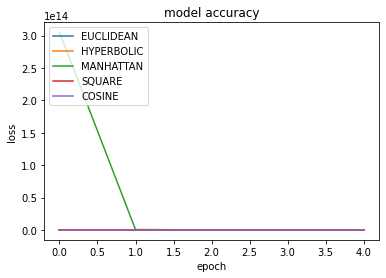

In [14]:
# plot loss for all distances
for key in DISTANCE_METRICS.keys():    
    plt.plot(objects[key]['history']['loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(list(DISTANCE_METRICS.keys()), loc='upper left')
plt.show()

Notice we have a huge dispersion and variance of the loss with respect to the distance functions. Lets take a closer look at the ones that are really low in the plot below.

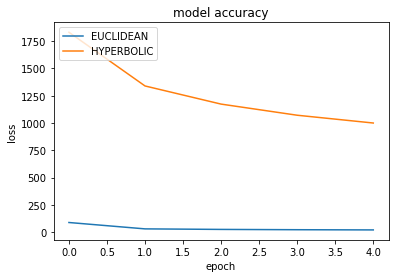

In [15]:
for key in ['EUCLIDEAN', 'HYPERBOLIC']: 
    if key != 'MANHATTAN' or key != 'SQUARE' or key != 'COSINE':
        plt.plot(objects[key]['history']['loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['EUCLIDEAN', 'HYPERBOLIC'], loc='upper left')
plt.show()

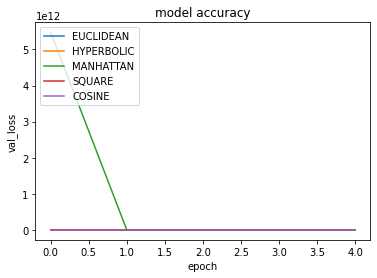

In [16]:
for key in DISTANCE_METRICS.keys():    
    plt.plot(objects[key]['history']['val_loss'])
plt.title('model accuracy')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(list(DISTANCE_METRICS.keys()), loc='upper left')
plt.show()

Notice we have a huge dispersion and variance of the val_loss with respect to the distance functions. Lets take a closer look at the ones that are really low in the plot below.

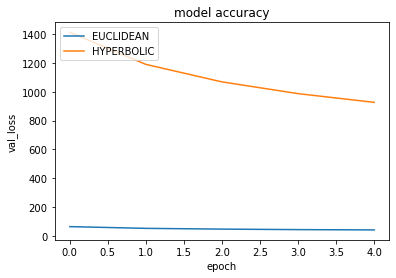

In [17]:
for key in ['EUCLIDEAN', 'HYPERBOLIC']: 
    if key != 'MANHATTAN' or key != 'SQUARE' or key != 'COSINE':
        plt.plot(objects[key]['history']['val_loss'])
plt.title('model accuracy')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['EUCLIDEAN', 'HYPERBOLIC'], loc='upper left')
plt.show()

# HyperParam Tunning with RandomSearchCV

In [23]:
from model.layer import DistanceLayer
from model.models_cstm import SiameseModel
from model.generator import SequenceDistDataGenerator

# followed tutorial from https://www.tensorflow.org/tutorials/keras/keras_tuner to customize RandomSearch
# for keras models
def model_builder_hyp(hp):
    # Model definitions
    in1 = tf.keras.layers.Input(name="sequence1", shape=(152,))
    in2 = tf.keras.layers.Input(name="sequence2", shape=(152,))
    
    #add activition func, and dropout valuse to the grid search for RandomCV
    hp_act_func = hp.Choice('act_func', values=ACTIVATION_SELECTIONS)
    hp_dropout = hp.Choice('dropout', values=DROPOUT_SELECTIONS)
    hp_num_units = hp.Choice('mlp_num_units_hidden', values=NUM_UNITS_SELECTIONS)
#     hp_num_filters = hp.Choice('cnn_num_filters', values=NUM_FILTERS_SELECTIONS)
    
    # get embedding model
    embedding_model = get_embedding_model(model_choice=MODEL_CHOICE, act_func=hp_act_func, dropout=hp_dropout,
                                    mlp_num_units_hidden=hp_num_units )
    
    # create distance, will compute distance from two embeddings
    distance = DistanceLayer(metric=DISTANCE_METRICS['HYPERBOLIC'], dynamic=True)(
        embedding_model(in1), 
        embedding_model(in2)
    )
    
    # create keras model
    siamese_network = tf.keras.models.Model(
        inputs=[in1, in2],
        outputs=distance
    )
    
    # add learning rate to search grid for RandomSearch
    hp_learning_rate = hp.Choice('learning_rate', values=LR_SELECTIONS)
    optimizer  = tf.keras.optimizers.Adam(hp_learning_rate, clipnorm=1)
    
    model = SiameseModel(siamese_network) # Depends on SiameseModel class, which we can define elsewhere
    model.compile(optimizer=optimizer) # run_eagerly is not necessary, but useful for debugging
    
    return model

def model_builder_euc(hp):
    # Model definitions
    in1 = tf.keras.layers.Input(name="sequence1", shape=(152,))
    in2 = tf.keras.layers.Input(name="sequence2", shape=(152,))
    
    #add activition func, and dropout valuse to the grid search for RandomCV
    hp_act_func = hp.Choice('act_func', values=ACTIVATION_SELECTIONS)
    hp_dropout = hp.Choice('dropout', values=DROPOUT_SELECTIONS)
    hp_num_units = hp.Choice('mlp_num_units_hidden', values=NUM_UNITS_SELECTIONS)
#     hp_num_filters = hp.Choice('cnn_num_filters', values=NUM_FILTERS_SELECTIONS)
    
    # get embedding model
    embedding_model = get_embedding_model(model_choice=MODEL_CHOICE, act_func=hp_act_func, dropout=hp_dropout,
                                    mlp_num_units_hidden=hp_num_units      )
    
    # create distance, will compute distance from two embeddings
    distance = DistanceLayer(metric=DISTANCE_METRICS['EUCLIDEAN'], dynamic=True)(
        embedding_model(in1), 
        embedding_model(in2)
    )
    
    # create keras model
    siamese_network = tf.keras.models.Model(
        inputs=[in1, in2],
        outputs=distance
    )
    
    # add learning rate to search grid for RandomSearch
    hp_learning_rate = hp.Choice('learning_rate', values=LR_SELECTIONS)
    optimizer  = tf.keras.optimizers.Adam(hp_learning_rate, clipnorm=1)
    
    model = SiameseModel(siamese_network) # Depends on SiameseModel class, which we can define elsewhere
    model.compile(optimizer=optimizer) # run_eagerly is not necessary, but useful for debugging
    
    return model

class MyTuner(keras_tuner.tuners.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial` 256, 512, 1024
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values = [256, 512, 1024])
        kwargs['epochs'] = NUM_EPOCHS

        X_val, y_val = kwargs['validation_data']
        training_generator = SequenceDistDataGenerator( X_train, y_train, batch_size = kwargs['batch_size'] )
        kwargs['validation_data'] = SequenceDistDataGenerator( X_val, y_val, batch_size = kwargs['batch_size'])
        
        return super(MyTuner, self).run_trial(trial, training_generator, **kwargs)

## RandomSearchCV Hyperparam Tuning (w/ Hyperbolic)

In [21]:
# Uses same arguments as the BayesianOptimization Tuner.
tuner = MyTuner(model_builder_hyp, objective='val_loss' , directory='hyper_param_tunning',
                     project_name=hyp_tuner_project_name, max_trials=6)

# Don't pass epochs or batch_size here, let the Tuner tune them.
# run the code below if you want to start search again
# tuner.search(X_train, y_train,  validation_data=(X_val,y_val),
#              callbacks= [tf.keras.callbacks.EarlyStopping('val_loss', patience=2)])

INFO:tensorflow:Reloading Oracle from existing project hyper_param_tunning/random_search_hyp_mlp_clipgrad/oracle.json
INFO:tensorflow:Reloading Tuner from hyper_param_tunning/random_search_hyp_mlp_clipgrad/tuner0.json


In [13]:
# Get the optimal hyperparameters
best_hps_HYPERBOLIC=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps_HYPERBOLIC
file_to_write = open( dist_res_path + "best_hyps_HYPERBOLIC.pkl", "wb")
pickle.dump(best_hps_HYPERBOLIC, file_to_write)


In [22]:
tuner.results_summary(1)

Results summary
Results in hyper_param_tunning/random_search_hyp_mlp_clipgrad
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
act_func: relu
dropout: 0.5
mlp_num_units_hidden: 128
learning_rate: 0.01
batch_size: 256
Score: 54.45589065551758


## RandomSearchCV Hyperparam Tuning (w/ Euclidean)

In [ ]:
# Uses same arguments as the BayesianOptimization Tuner.
tuner = MyTuner(model_builder_euc, objective='val_loss', directory='hyper_param_tunning',
                     project_name=euc_tuner_project_name,  max_trials=6)

# Don't pass epochs or batch_size here, let the Tuner tune them.
# run the code below if you want to start search again
# tuner.search(X_train, y_train,  validation_data=(X_val,y_val),
#              callbacks= [tf.keras.callbacks.EarlyStopping('val_loss', patience=2)])

In [19]:
# Get the optimal hyperparameters
best_hps_EUCLIDEAN=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps_EUCLIDEAN
file_to_write = open( dist_res_path + "best_hyps_EUCLIDEAN.pkl", "wb")
pickle.dump(best_hps_EUCLIDEAN, file_to_write)

In [20]:
tuner.results_summary(1)

Results summary
Results in hyper_param_tunning/random_search_euc_mlp_clipgrad
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
act_func: relu
dropout: 0.3
mlp_num_units_hidden: 128
learning_rate: 0.0001
batch_size: 256
Score: 32.98936080932617
